In [ ]:
!pip install yfinance

In [ ]:
!pip install numpy pandas matplotlib statsmodels tensorflow


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [4]:
df = yf.download("AAPL", start="2015-01-01", end="2024-01-01")
company = 'Apple'
# Create a new dataframe with relevant features
stock_data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402174,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714722,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716959,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049517,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973555,237458000
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


Text(0.5, 1.0, 'Apple stock closing price')

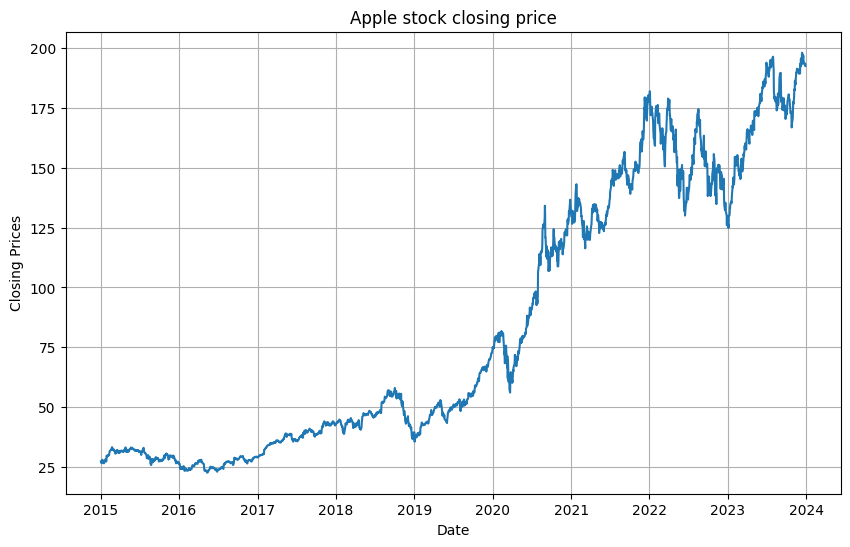

In [6]:
df_close = stock_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Apple stock closing price')

In [7]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

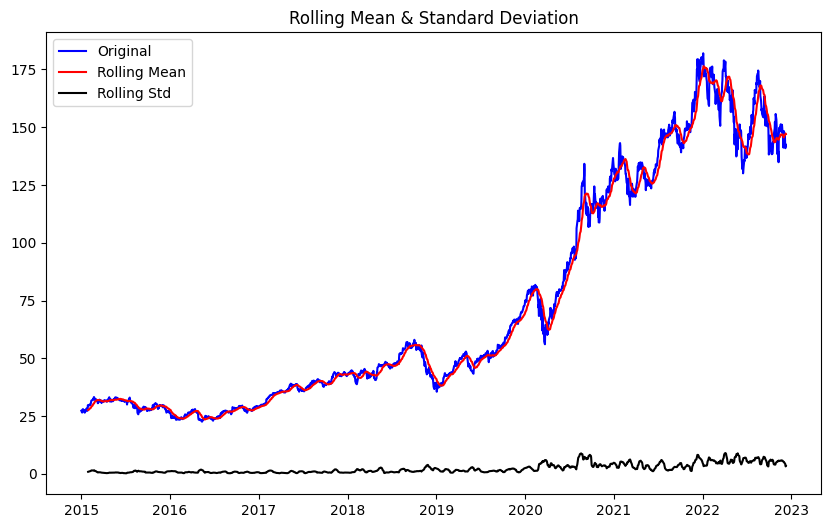

Results of Dickey-Fuller Test:
Test Statistic                   -0.354974
p-value                           0.917349
#Lags Used                       22.000000
Number of Observations Used    1977.000000
Critical Value (1%)              -3.433662
Critical Value (5%)              -2.863003
Critical Value (10%)             -2.567549
dtype: float64


In [8]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

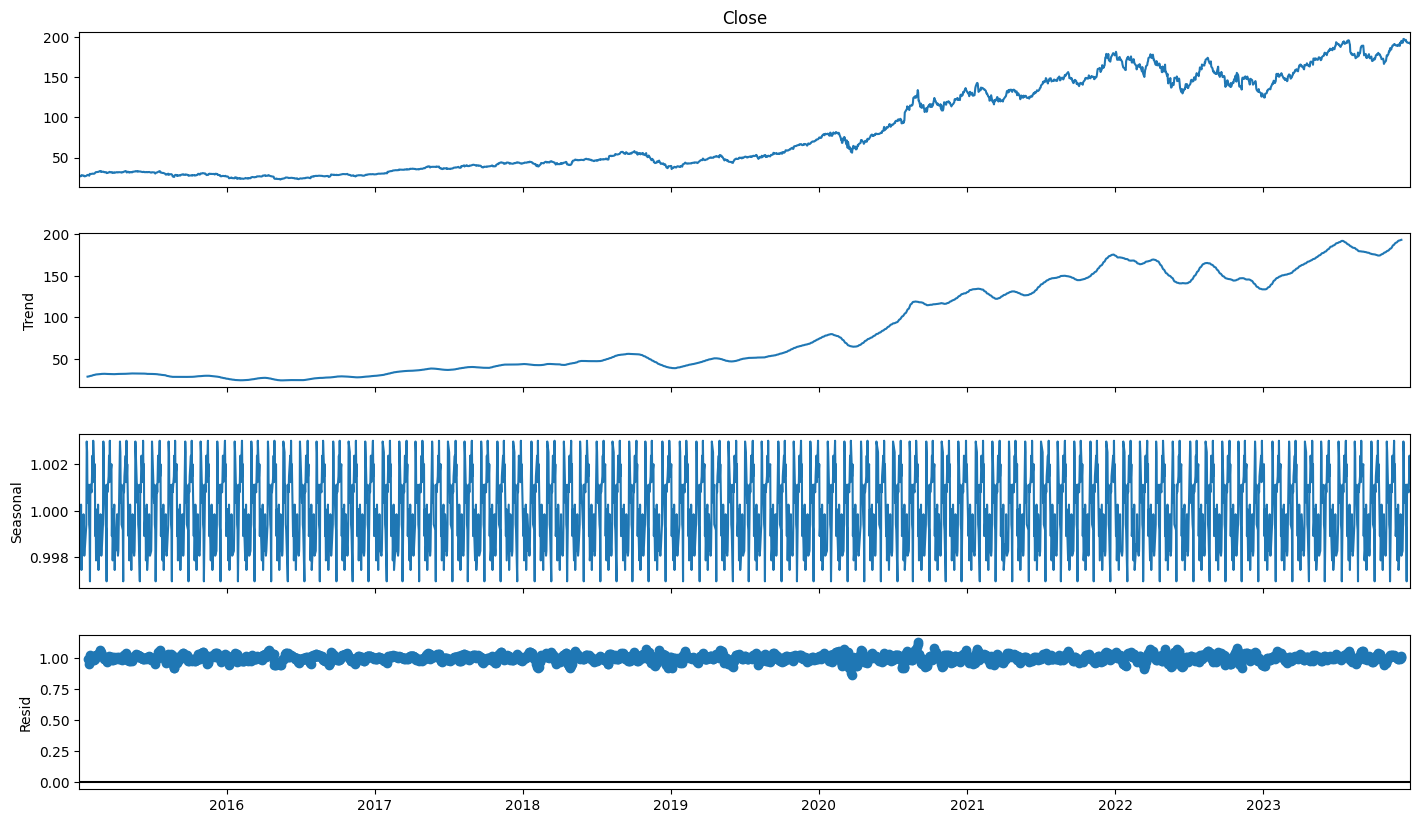

In [9]:
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

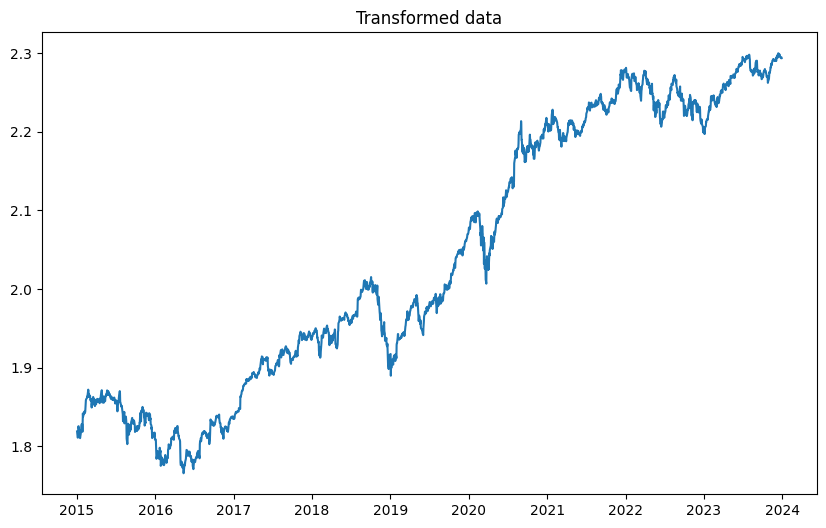

In [10]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

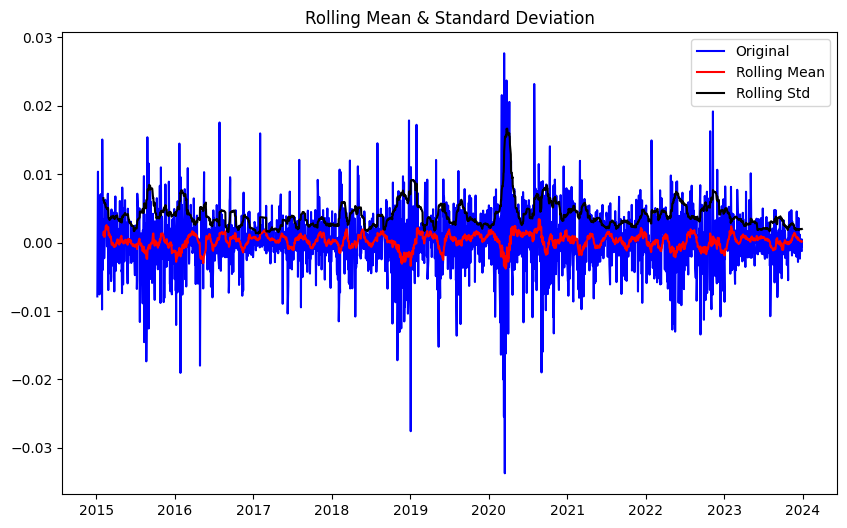

Results of Dickey-Fuller Test:
Test Statistic                -1.462632e+01
p-value                        3.813849e-27
#Lags Used                     8.000000e+00
Number of Observations Used    2.254000e+03
Critical Value (1%)           -3.433255e+00
Critical Value (5%)           -2.862823e+00
Critical Value (10%)          -2.567453e+00
dtype: float64


In [11]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [12]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [13]:
nb_days = 60
# choose the number of days on which to base our predictions
n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [14]:
#Split the data set between the training set and the test set
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

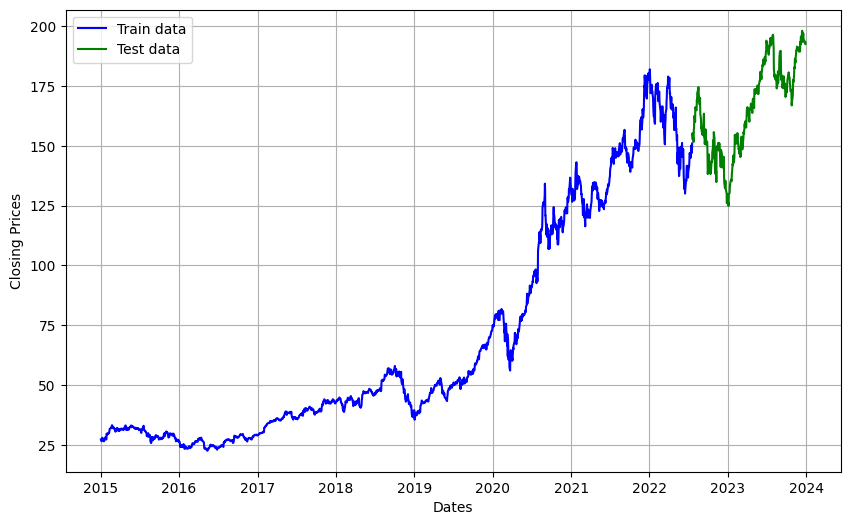

In [15]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [16]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [17]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.3114e-05 - mean_absolute_error: 0.0044
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.4263e-05 - mean_absolute_error: 0.0034
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.1606e-05 - mean_absolute_error: 0.0033
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3303e-05 - mean_absolute_error: 0.0034
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.2567e-05 - mean_absolute_error: 0.0033
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.3377e-05 - mean_absolute_error: 0.0034
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.2003e-05 - mean_absolute_error: 0.0033
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.2733e-05 - mean_absolute_error: 0.0034
Epoch 9/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.2381e-05 - mean_absolute_error: 0.0034
Epoch 10/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.3097e-05 - mean_absolute_error: 0.0035

In [ ]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.8658e-05 - mean_absolute_error: 0.0032
Test MSE: 1.4174320313031785e-05
Test MAE: 0.0027549401856958866


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


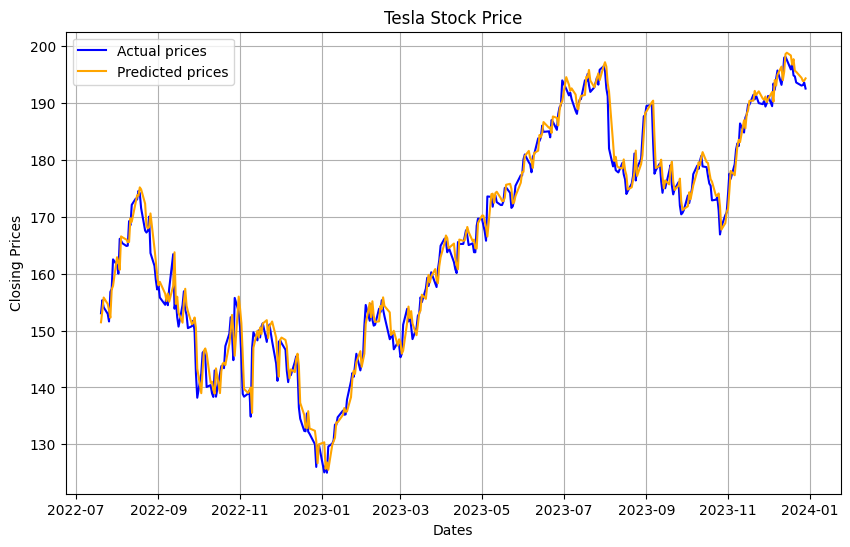

In [ ]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

In [22]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

In [23]:
# Number of days into the future we want to predict
n_steps_out = 10

# choose the number of days on which to base our predictions
nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)

In [24]:
#Split the data set between the training set and the test set
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [25]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [26]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,910 (42.62 KB)

 Trainable params: 10,910 (42.62 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1086e-05 - mean_absolute_error: 0.0032
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.2894e-05 - mean_absolute_error: 0.0033
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.2212e-05 - mean_absolute_error: 0.0032
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.0850e-05 - mean_absolute_error: 0.0032
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.1748e-05 - mean_absolute_error: 0.0032
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.4046e-05 - mean_absolute_error: 0.0034
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.0782e-05 - mean_absolute_error: 0.0032
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 2.0970e-05 - mean_absolute_error: 0.0032
Epoch 9/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.9104e-05 - mean_absolute_error: 0.0031
Epoch 10/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.5959e-05 - mean_absolute_error: 0.0034

In [27]:
# Evaluate the model on the test set
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8197e-05 - mean_absolute_error: 0.0032
Test MSE: 1.3916882380726747e-05
Test MAE: 0.002729563508182764


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

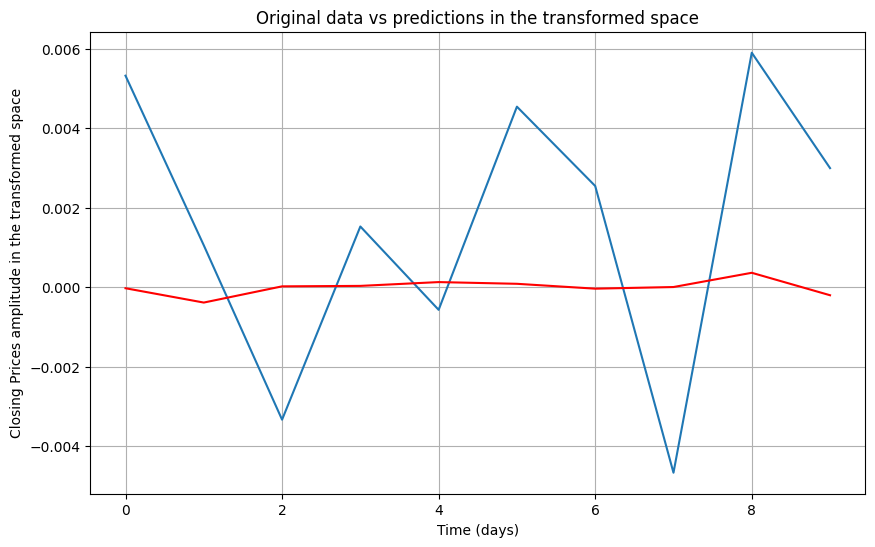

In [28]:
# Prediction
y_pred = model.predict(X_test)

# Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [29]:
# Apply inverse transformations from 3.a

# Add the differenciation term
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2022-07-20    2.220270
2022-07-21    2.219884
2022-07-22    2.219905
2022-07-25    2.219938
2022-07-26    2.220067
2022-07-27    2.220152
2022-07-28    2.220115
2022-07-29    2.220120
2022-08-01    2.220482
2022-08-02    2.220280
dtype: float64


In [30]:
# Take the square, and the exponent
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2022-07-20    138.324007
2022-07-21    138.087014
2022-07-22    138.100128
2022-07-25    138.120320
2022-07-26    138.199157
2022-07-27    138.251608
2022-07-28    138.229015
2022-07-29    138.231648
2022-08-01    138.454245
2022-08-02    138.330034
dtype: float64


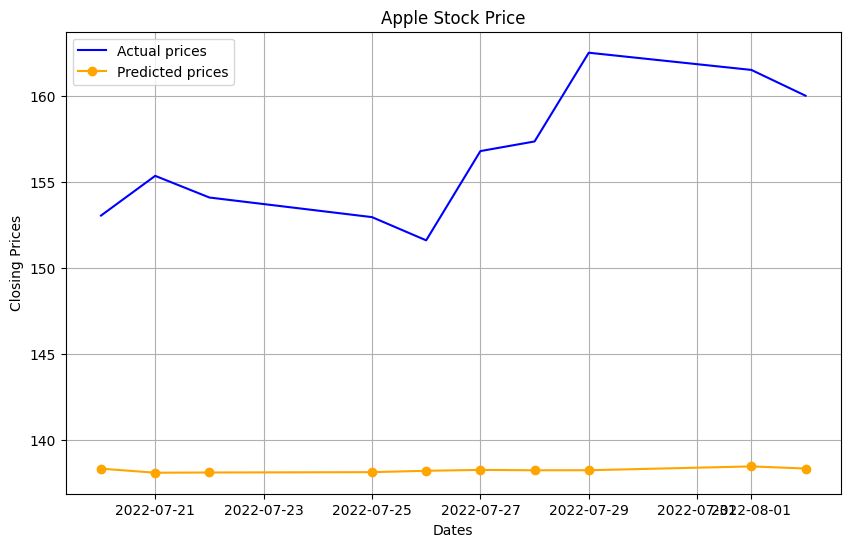

In [32]:
# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()